# Create Monthly CESM ice flux files

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
from mpl_toolkits.basemap import Basemap, cm
import pickle
import pandas as pd
import datetime as dt
import xarray as xr
import cmocean
import matplotlib
import modules.mapping_functions as mf
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#### Parameters

In [2]:
data_folder = '/data/brogalla/NCAR-CESM2/'

# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

#### Load files

In [3]:
mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask = np.array(mesh.variables['tmask'])
tmask = np.array(tmask[0,:,:,:])
ANHA12_lons = np.array(mesh.variables['nav_lon'])
ANHA12_lats = np.array(mesh.variables['nav_lat'])
Z_masked = np.ma.masked_where((tmask > 0.1), tmask) 

In [4]:
# ---- Load data: ------------
# Black carbon:
BC1 = xr.open_dataset(f'{data_folder}b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.SEAICE_BLACK_CARBON_FLUX_CPL.200001-200912.nc')
BC2 = xr.open_dataset(f'{data_folder}b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.SEAICE_BLACK_CARBON_FLUX_CPL.201001-201412.nc')
BC3 = xr.open_dataset(f'{data_folder}b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.pop.h.SEAICE_BLACK_CARBON_FLUX_CPL.201501-202412.nc')
ICE_BC1  = BC1['SEAICE_BLACK_CARBON_FLUX_CPL'].values # time, lat, lon; g/cm2/s
ICE_BC2  = BC2['SEAICE_BLACK_CARBON_FLUX_CPL'].values
ICE_BC3  = BC3['SEAICE_BLACK_CARBON_FLUX_CPL'].values
BC1_time = BC1.indexes['time'].to_datetimeindex() 
BC2_time = BC2.indexes['time'].to_datetimeindex() 
BC3_time = BC3.indexes['time'].to_datetimeindex() 
# combine:
ICE_BC   = np.vstack([ICE_BC1, ICE_BC2, ICE_BC3])
BC_time  = np.hstack([BC1_time, BC2_time, BC3_time])
BC_date  = np.array([pd.Timestamp(time).to_pydatetime() for time in BC_time])
  
# Dust:
DST1 = xr.open_dataset(f'{data_folder}b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.SEAICE_DUST_FLUX_CPL.200001-200912.nc')
DST2 = xr.open_dataset(f'{data_folder}b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.SEAICE_DUST_FLUX_CPL.201001-201412.nc')
DST3 = xr.open_dataset(f'{data_folder}b.e21.BSSP370cmip6.f09_g17.LE2-1001.001.pop.h.SEAICE_DUST_FLUX_CPL.201501-202412.nc')
ICE_DST1  = DST1['SEAICE_DUST_FLUX_CPL'].values # time, lat, lon; g/cm2/s
ICE_DST2  = DST2['SEAICE_DUST_FLUX_CPL'].values
ICE_DST3  = DST3['SEAICE_DUST_FLUX_CPL'].values
DST1_time = DST1.indexes['time'].to_datetimeindex() 
DST2_time = DST2.indexes['time'].to_datetimeindex() 
DST3_time = DST3.indexes['time'].to_datetimeindex()
# combine:
ICE_DST   = np.vstack([ICE_DST1, ICE_DST2, ICE_DST3])
DST_time  = np.hstack([DST1_time, DST2_time, DST3_time])
DST_date  = np.array([pd.Timestamp(time).to_pydatetime() for time in DST_time])
    
# Latitudes and longitudes of T grid points
CESM2_lons = BC1['TLONG'].values
CESM2_lons[CESM2_lons >=180] = -360 + CESM2_lons[CESM2_lons >=180] # degrees east
CESM2_lats = BC1['TLAT'].values

#### Functions

In [5]:
def save_file(filename, field1, field2):
    ncd = nc.Dataset(filename, 'w', zlib=True)
    ncd.createDimension('x',len(mesh.dimensions['x']))
    ncd.createDimension('y',len(mesh.dimensions['y']))
    ncd.createDimension('time_counter',None)
    
    # convert units from g/cm2/s to kg/m2/s:
    field1_convert = field1*10
    field2_convert = field2*10
    
    # variables
    dust             = ncd.createVariable('dust', 'float64', ('y','x'))
    dust.units       = 'kg/m2/s'
    dust.long_name   = 'Dust deposition flux from ice'  
    dust.coordinates = 'nav_lon nav_lat'
    dust[:]          = field1_convert
    
    black_c             = ncd.createVariable('bc', 'float64', ('y','x'))
    black_c.units       = 'kg/m2/s'
    black_c.long_name   = 'Black carbon deposition flux from ice'  
    black_c.coordinates = 'nav_lon nav_lat'
    black_c[:]          = field2_convert
    
    print('saved ', filename)

    ncd.close()
    return

In [6]:
def find_dates(file_year):
    
    indices = np.array([])
    for d,date in enumerate(DST_date):
        if date.year==file_year:
            indices = np.append(indices, d)
            
    start_index = int(np.amin(indices))
    end_index   = int(np.amax(indices))
    
    print('start index: ', start_index)
    print('end index: ', end_index)
    
    return start_index, end_index

In [7]:
def CESM_to_ANHA12(file_year, savefiles=False):
    
    si, ei = find_dates(file_year)
    
    dust         = ICE_DST[si:ei+1,:,:]
    black_carbon = ICE_BC[si:ei+1,:,:]
    print('Check that output is of the correct dimensions: ', dust.shape, black_carbon.shape)
    
    interp_dust         = np.empty((12, 2400, 1632))
    interp_black_carbon = np.empty((12, 2400, 1632))
    # loop over the months:
    for i in range(0,12):
        # Mask NaN values and remove
        dstm = np.ma.masked_where(np.isnan(dust[i,:,:]), dust[i,:,:])
        bcm  = np.ma.masked_where(np.isnan(black_carbon[i,:,:]), black_carbon[i,:,:])
        
        interp_dust[i,:,:]         = mf.interp_np(CESM2_lons[~dstm.mask], CESM2_lats[~dstm.mask], \
                                                  dstm[~dstm.mask], ANHA12_lons, ANHA12_lats)
        interp_black_carbon[i,:,:] = mf.interp_np(CESM2_lons[~bcm.mask], CESM2_lats[~bcm.mask], \
                                                  bcm[~bcm.mask], ANHA12_lons, ANHA12_lats)
        
    if savefiles:
        location = '/ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/seaice/'
        
        for ind in range(1,13):
            save_file(f'{location}ice_flux_y{file_year}m{ind:02}.nc',interp_dust[ind-1,:,:],\
                      interp_black_carbon[ind-1,:,:])
    
    return interp_dust, interp_black_carbon

#### Calculations

In [ ]:
for year in np.arange(2020,2022,1):
    print(year)
    interp_dust, interp_black_carbon = CESM_to_ANHA12(year, savefiles=True)

2020
start index:  239
end index:  250
Check that output is of the correct dimensions:  (12, 384, 320) (12, 384, 320)
saved  /ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/seaice/ice_flux_y2020m01.nc
saved  /ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/seaice/ice_flux_y2020m02.nc
saved  /ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/seaice/ice_flux_y2020m03.nc
saved  /ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/seaice/ice_flux_y2020m04.nc
saved  /ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/seaice/ice_flux_y2020m05.nc


# Visualize some of the forcing files

In [39]:
def plot_forcing_field(variable, vrange=(0,10)):
    
    fig, ax, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj(ANHA12_lons[imin:imax,jmin:jmax], ANHA12_lats[imin:imax,jmin:jmax])
    
    var_plot = variable[imin:imax,jmin:jmax]

    proj.pcolormesh(x, y, var_plot, vmin=vrange[0], vmax=vrange[1], cmap=cmocean.cm.deep_r, zorder=2)
    
    return

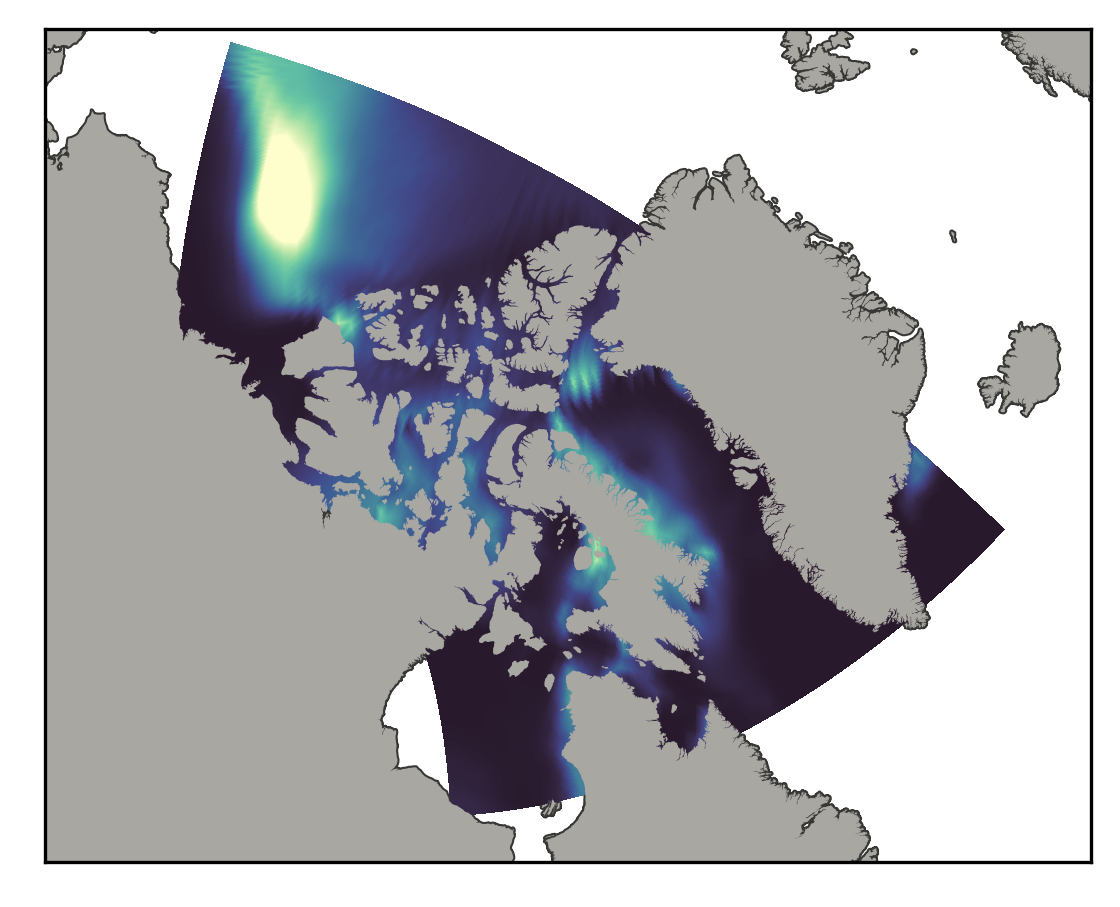

In [40]:
plot_forcing_field(interp_dust[8,:,:], vrange=(0,3e-12))

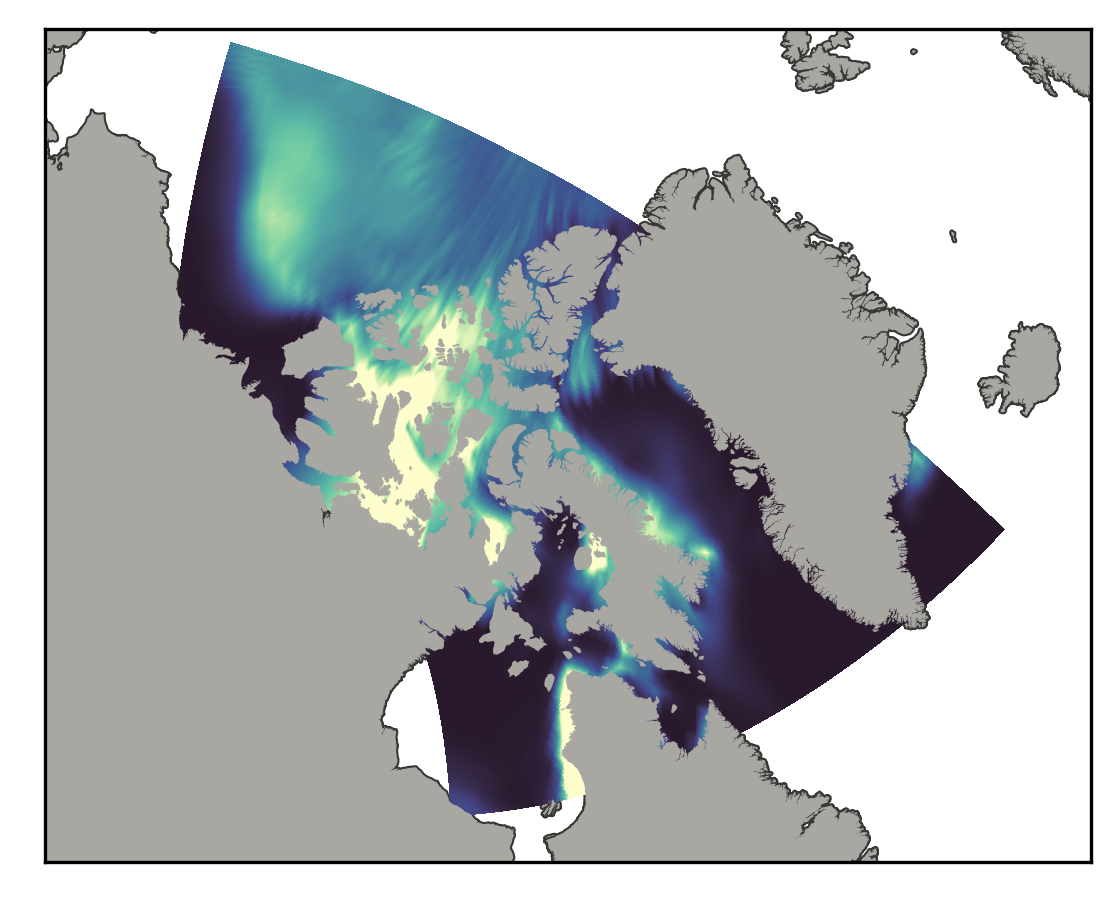

In [41]:
plot_forcing_field(interp_black_carbon[8,:,:], vrange=(0,1e-14))